In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Step1: Format and clean the data. Eliminating the sample with small amplitude
from clean import *
import argparse

In [91]:
# Construct the argument
parser = argparse.ArgumentParser(description='Cleaning audio data')
parser.add_argument('--src_root', type=str, default='wavfiles',
                    help='directory of audio files in total duration')
parser.add_argument('--dst_root', type=str, default='clean',
                    help='directory to put audio files split by delta_time')
parser.add_argument('--delta_time', '-dt', type=float, default=1.0,
                    help='time in seconds to sample audio')
parser.add_argument('--sr', type=int, default=16000,
                    help='rate to downsample audio')
parser.add_argument('--plotfile', type=str, default='3a3d0279',
                    help='directory of audio files in total duration')
parser.add_argument('--threshold', type=str, default=20,
                    help='threshold magnitude for np.int16 dtype')
args, _ = parser.parse_known_args()


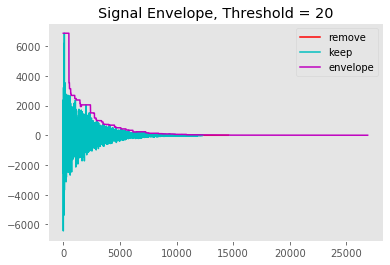

In [92]:
test_threshold(args)

In [113]:
# Split the long wav file into small segments, which has sample time equal to delta_time set in previous cell
split_wavs(args)

  0%|          | 0/30 [00:00<?, ?it/s]

clean exists
clean\Acoustic_guitar does not exist


 10%|█         | 3/30 [00:00<00:01, 20.85it/s]

clean\Bass_drum does not exist


  3%|▎         | 1/30 [00:00<00:03,  8.00it/s]

clean\Cello does not exist


  3%|▎         | 1/30 [00:00<00:03,  7.48it/s]

clean\Clarinet does not exist


  7%|▋         | 2/30 [00:00<00:02, 13.28it/s]

clean\Double_bass does not exist


  3%|▎         | 1/30 [00:00<00:05,  5.62it/s]

clean\Flute does not exist


  3%|▎         | 1/30 [00:00<00:03,  9.17it/s]

clean\Hi_hat does not exist


  7%|▋         | 2/30 [00:00<00:02, 10.49it/s]

clean\Saxophone does not exist


  0%|          | 0/30 [00:00<?, ?it/s]

clean\Snare_drum does not exist


  3%|▎         | 1/30 [00:00<00:04,  6.07it/s]

clean\Violin_or_fiddle does not exist


100%|██████████| 30/30 [00:03<00:00,  8.14it/s]
